## Grid search



In [2]:
# Import necessary functions and modules from the script
from LSTM_Model_Training import (
    get_config,
    preprocess_aachen_dataset,
    plot_training_history,
    plot_predictions_vs_actual,
    plot_residuals,
    save_model_structure_and_weights,
    load_model_structure_and_weights,
    get_unique_model_name
)

import pandas as pd
import tensorflow as tf
import keras_tuner as kt
from keras_tuner.tuners import BayesianOptimization

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [6]:
def build_model(hp):
    """
    Keras Tuner-compatible model function.
    Hyperparameters (hp) are dynamically tuned.
    """
    model = Sequential([
        Masking(mask_value=0.0, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
        LSTM(hp.Int("lstm_units", min_value=16, max_value=64, step=16), activation='tanh'),
        Dropout(hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)),
        Dense(hp.Int("dense_units", min_value=8, max_value=64, step=8), activation='tanh'),
        Dense(1)  # Output layer for regression
    ])

    optimizer = Adam(learning_rate=hp.Choice("learning_rate", values=[0.001, 0.01, 0.1]))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [7]:
def run_keras_tuner(X_train, y_train, X_val, y_val):
    """Runs Keras Tuner for hyperparameter search."""
    
    tuner = BayesianOptimization(
        build_model,
        objective="val_loss",
        max_trials=10,  # Number of models to test
        executions_per_trial=1,  # Number of times to train each model
        directory="hyperparameter_tuning",
        project_name="lstm_tuning"
    )

    # Run hyperparameter search
    tuner.search(X_train, y_train, 
                 epochs=20,  # Shorter for tuning, increase later
                 validation_data=(X_val, y_val),
                 batch_size=32, 
                 verbose=1)

    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print(f"\nBest Hyperparameters:")
    print(f"LSTM Units: {best_hps.get('lstm_units')}")
    print(f"Dense Units: {best_hps.get('dense_units')}")
    print(f"Dropout Rate: {best_hps.get('dropout_rate')}")
    print(f"Learning Rate: {best_hps.get('learning_rate')}")
    
    return best_hps

In [8]:
use_keras_tuner = True

filename = "/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/data/Degradation_Prediction_Dataset_ISEA.mat"

# Load configuration
config = get_config()

# Load and preprocess the Aachen dataset
aachen_data = preprocess_aachen_dataset(
    filename,
    eol_capacity=0.65,
    test_cell_count=3,
    random_state=42,
    phase="Mid",
    log_transform=False,
)

# Extract the preprocessed data
X_train_lstm = aachen_data["X_train"]
X_val_lstm = aachen_data["X_val"]
X_test_lstm = aachen_data["X_test"]
y_train = aachen_data["y_train"]
y_val = aachen_data["y_val"]
y_test = aachen_data["y_test"]
y_max = aachen_data["y_max"]

# Define model name for loading
model_name = None

if model_name is None:
    model_name = get_unique_model_name()

# Check if a trained model exists
try:
    print("Attempting to load pre-trained model...")
    model = load_model_structure_and_weights(model_name)
    print("Pre-trained model loaded successfully.")
except FileNotFoundError:
    print("No pre-trained model found. Training a new model...")

    if use_keras_tuner:
        print("Running hyperparameter tuning with Keras Tuner...")
        best_hps = run_keras_tuner(X_train_lstm, y_train, X_val_lstm, y_val)

        # Update config with best hyperparameters
        config["lstm_units"] = best_hps.get("lstm_units")
        config["dropout_rate"] = best_hps.get("dropout_rate")
        config["dense_units"] = best_hps.get("dense_units")
        config["learning_rate"] = best_hps.get("learning_rate")


Trial 10 Complete [00h 02m 47s]
val_loss: 0.002799303038045764

Best val_loss So Far: 0.00269808666780591
Total elapsed time: 00h 31m 11s

Best Hyperparameters:
LSTM Units: 64
Dense Units: 24
Dropout Rate: 0.1
Learning Rate: 0.01


In [9]:
best_hps

/opt/miniconda3/envs/D2D_env/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - loss: 0.0238 - mae: 0.0955 - val_loss: 0.0052 - val_mae: 0.0522
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - loss: 0.0043 - mae: 0.0504 - val_loss: 0.0029 - val_mae: 0.0428
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0033 - mae: 0.0447 - val_loss: 0.0029 - val_mae: 0.0438
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0034 - mae: 0.0449 - val_loss: 0.0052 - val_mae: 0.0498
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0042 - mae: 0.0497 - val_loss: 0.0035 - val_mae: 0.0408
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0032 - mae: 0.0436 - val_loss: 0.0028 - val_mae: 0.0412
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.0031 - mae: 0.0428 - val_loss: 0.0035 - val_mae: 0.0435
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.0033 - mae: 0.0436 - val_loss: 0.0033 - val_mae: 0.0473
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 

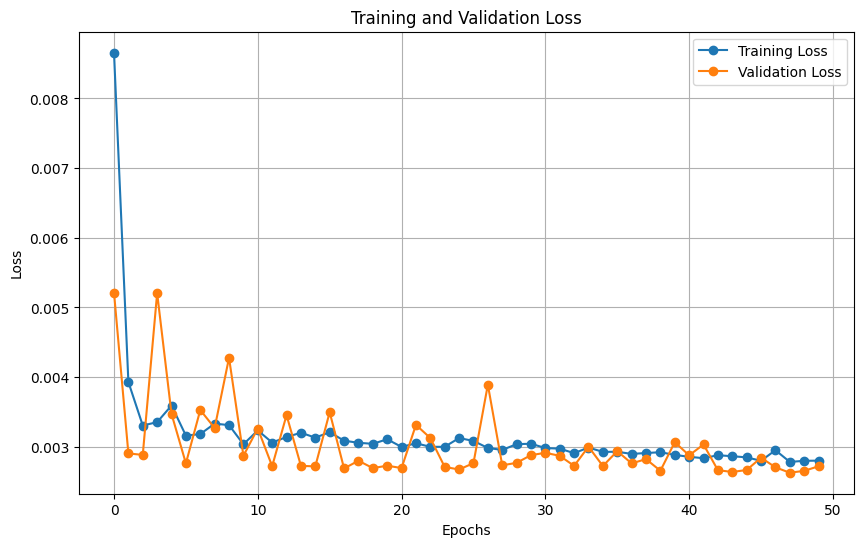

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.3934e-04 - mae: 0.0159

Test Loss: 0.00047858335892669857
Test MAE: 0.018127070739865303
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
   Actual RUL80  Predicted RUL80
0        1305.0      1269.743408
1        1300.0      1266.209717
2        1295.0      1262.153320
3        1290.0      1257.608276
4        1285.0      1252.736450


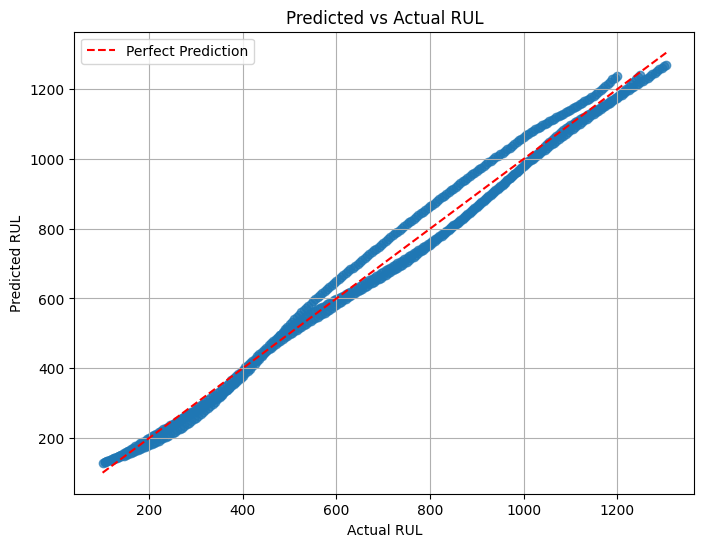

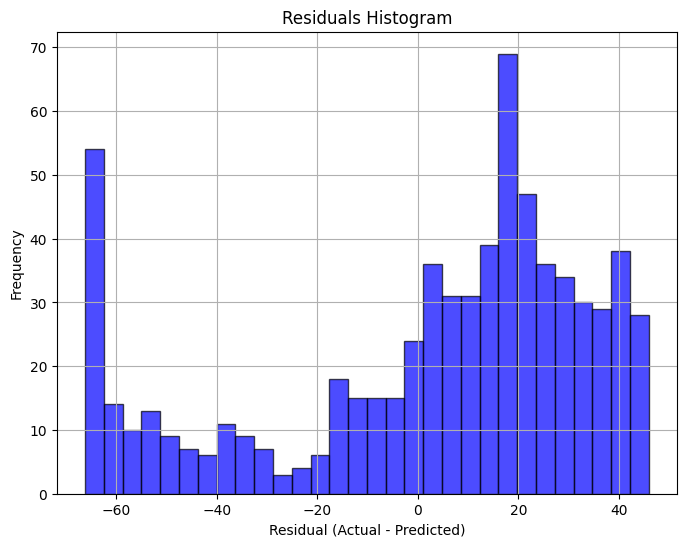

In [10]:
# Build the model
model = build_model(best_hps)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

# Train the model
history = model.fit(
    X_train_lstm, y_train,
    validation_data=(X_val_lstm, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)

# Define model name for loading
model_name = None

if model_name is None:
    model_name = get_unique_model_name()

# Save the best model after training
save_model_structure_and_weights(model, model_name)
print(f"New model saved as {model_name}")

# Plot training history
plot_training_history(history)

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

# Plot predictions vs actual
plot_predictions_vs_actual(y_test_rescaled, y_pred_rescaled)

# Plot residuals
plot_residuals(y_test_rescaled, y_pred_rescaled)